# Titanic Survival Classification

The HTML reports for this notebook are available at the below location:  
https://drive.google.com/drive/u/0/folders/1BRr9tLGupWNDEp4IcIS13HtqVQgiTZnS

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import os
import sys

sys.path.append(os.path.join(os.getcwd(),"../.." ))
from utils import load_yml
import eda
import model_gen
import model_eval
import feature_selection as fs
import data_processing as dp

file_path =  'D:/TigerML/code_templates-classification-scripts/case_examples/titanic/config.yml'

## Config file

## Config file

### dataset : https://www.kaggle.com/c/titanic/data
### yml file : Consists of hard coded configuration such as: 

###### dataset_path - local directory path with data
###### estimator_path - local directory with estimators (models and grid search parameters)
###### target_column - binary dependent variable column name in dataset.
###### train_ratio - train and testing dataset split ratio for model building.
###### drop_cols - columns / variables to remove from datatset.
###### numeric_impute and categorical_impute
###### fs - feature selection type (recursion - sklearn feature selection / fs - mlxtend feature selection)
###### fs_params - parameters related to feature selection model 

In [2]:
config_file = load_yml(file_path)
print(config_file)

{'dataset_path': 'D:/TigerML/code_templates-classification-scripts/titanic.csv', 'estimator_config_path': 'D:/TigerML/code_templates-classification-scripts/case_examples/titanic/estimators.yml', 'target_column': 'survived', 'output_path': 'D:/TigerML/code_templates-classification-scripts/case_examples/titanic/model_output.csv', 'train_ratio': 0.8, 'seed': 13, 'drop_cols': [], 'numeric_impute': 'mean', 'categorical_impute': 'mode', 'fs': 'recursion', 'feature_selection': {'regularization': {'estimator': 'sklearn.linear_model.Ridge', 'estimator_params': {'alpha': 0.5}}, 'recursion': {'estimator': 'sklearn.linear_model.Ridge', 'estimator_params': {'alpha': 0.5}, 'fs_params': {'forward': False, 'verbose': False, 'k_features': 'best'}}}}


## Data Processing

In [3]:
df_data = dp.load_dataset(config_file['dataset_path'],drop_cols=config_file['drop_cols'],target_col=config_file['target_column'])

In [4]:
df_data.head()

### Health Analysis

#### We will convert the pandas dataframe to Analyser class of TigerML for further analysis

In [5]:
an = eda.Analyser(data = df_data)

##### Glimpse through features and datatypes

In [6]:
an.variable_summary()

Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds


###### Continuous variables - Fare, Age, Sibsp, Parch
###### Categorical variables - embarked, pclass, sex
###### Survived is the target variable with event rate of 38%
###### Name, Cabin and ticket variables are ID variables. We can drop those columns from the dataset

In [7]:
drop_cols = ['name','ticket','cabin']
df_data.drop(drop_cols, axis = 1, inplace = True)
df_data.head()

##### Exploring missing values in the dataset

In [8]:
an = eda.Analyser(data = df_data)
an.missing_value_summary()

Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds


index Variable Name  No of Missing  Per of Missing
0      7      embarked              2        0.224467

#### We observe that embarked variable has 2 missing values in the dataset. Imputing the missing values in embarked column with mode value.

In [9]:
df_data['embarked'] = dp.Imputer(df_data[['embarked']], cat_impute_method = config_file['categorical_impute']).transform()

There are 2 missing values in the variable - embarked
All missing values are imputed with mode


In [10]:
## checking dataframe for Imputation
df_data.isna().sum()._data

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

#### Outliers

In [11]:
df_outliers = an.get_outliers_df().reset_index()
df_outliers[df_outliers['feature'].isin(['age','fare'])]

feature  < (mean-3*std)  > (mean+3*std)  < (1stQ - 1.5 * IQR)  \
0     age               0               7                    24   
1    fare               0              20                     0   

   > (3rdQ + 1.5 * IQR)  -inf  +inf  
0                    42     0     0  
1                   116     0     0

#### we observe that there are several values above and below the lower(1st - 1.5 IQR)  and upper (3rd + 1.5 IQR)  fence. 

## EDA 

### Univariate Analysis 

FROM REPORT

Sex - Proportion of males is 64%

Embarked - Passenger from southampton occupy 75% of titanic.

Fare - The distribution of ticket fare is right skewed and passengers with cheaper tickets are more in number

Age - Passengers between 18-30 contribute to most proportion of the ship.

Started running health_analysis
Started running data_health
Started running duplicate_columns
Finished running duplicate_columns
Time taken to run duplicate_columns is 0 seconds
Finished running data_health
Time taken to run data_health is 0 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds
Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds
Finished running health_analysis
Time taken to run health_analysis is 0 seconds
Started running preprocess_data
Cleaning data
No missing values
No Infinity values
Have 1 boolean variables. Converting False to 0 and True to 1
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
Finished running preprocess_data
Time taken to run preprocess_data is 0 seconds
Started running feature_analysis
Started running numeric_summary
Started ru

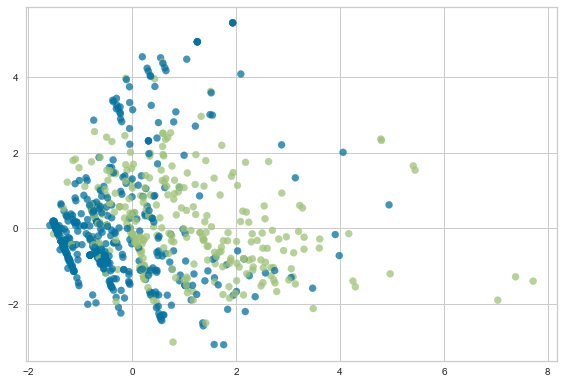

In [12]:
eda.perform_eda(df_data, config_file['target_column'])

### Bivariate Analysis

#### Joint Plots

In [13]:
joint_object = eda.JointPlot(df_data)
joint_plots = joint_object.get_plots(x_vars = ['sex','embarked'], y_vars = ['survived']) 

In [14]:
joint_plots['sex']['survived']

:Bars   [sex,Variable]   (value)

##### Survival rate of woman is much higher than survival rate of men. 

In [15]:
joint_plots['embarked']['survived']

:Bars   [embarked,Variable]   (value)

##### Survival rate of passengers from port of embarment S (southhamtop) is the highest.
##### Target encoding variables sex and embarked can help the model as its represent survival rate at each category of the categorical variable

#### Overlapping histograms

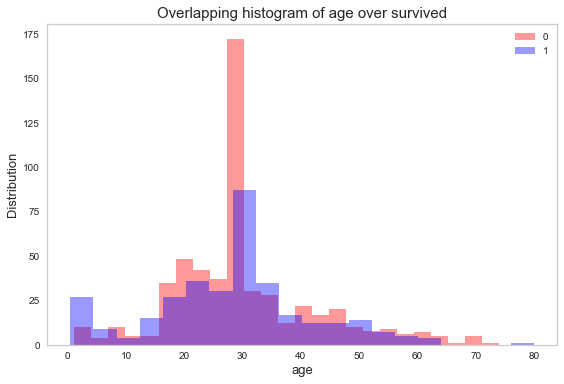

In [16]:
eda.overlapping_histograms(df_data,'age','survived')

##### Children younger than 10 had a better survival rate in comparison with passengers of age between 19 - 29.

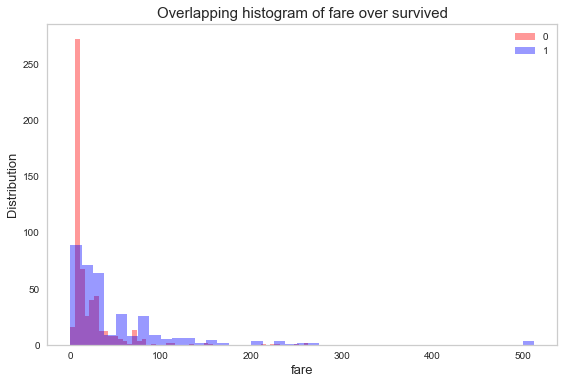

In [17]:
eda.overlapping_histograms(df_data,'fare','survived')

##### We observe that passengers who have had a higer fare have good survival rate, to obtain a better view of our hypothesis a log transformation could be applied on "fare" variable to see if our hypothesis is true.

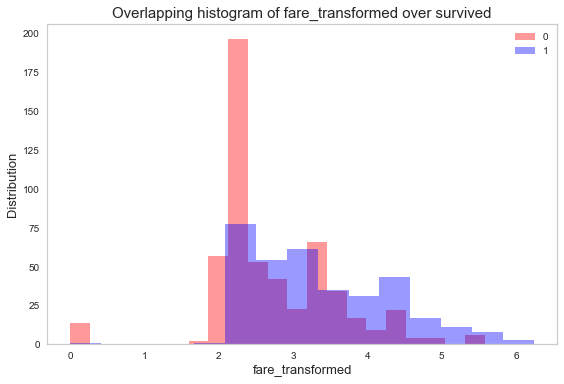

In [18]:
df_data['fare_transformed'] = np.log1p(df_data['fare'])
eda.overlapping_histograms(df_data,'fare_transformed','survived')

##### survival rate is low for cheaper tickets/cabins.

In [19]:
## Dropping fare column 
df_data.drop('fare', axis = 1, inplace = True)

#### Generating health report as HTML 

In [20]:
an.health_analysis(save_as = '.html')

Started running health_analysis
Started running data_health
Started running duplicate_columns
Finished running duplicate_columns
Time taken to run duplicate_columns is 0 seconds
Finished running data_health
Time taken to run data_health is 0 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds
Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds
Finished running health_analysis
Time taken to run health_analysis is 1 seconds


{'health_plot': :Layout
    .Bars.I   :Bars   [index,Variable]   (value)
    .Bars.II  :Bars   [index,Variable]   (value)
    .Bars.III :Bars   [index,Variable]   (value)
    .Bars.IV  :Bars   [index,Variable]   (value),
 'missing_plot': :Bars   [index]   (0),
 'missing_value_summary': 'No Missing Values',
 'duplicate_columns': 'No duplicate variables',
 'outliers_in_features':                   < (mean-3*std)  > (mean+3*std)  < (1stQ - 1.5 * IQR)  \
 feature                                                                  
 age                            0               7                    24   
 fare_transformed              15               3                    15   
 parch                          0              15                     0   
 sibsp                          0              30                     0   
 
                   > (3rdQ + 1.5 * IQR)  -inf  +inf  
 feature                                             
 age                                 42     0     0  
 fare_

#### Feature Analysis

In [21]:
an.feature_analysis(save_as=".html")

Started running feature_analysis
Started running numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running numeric_summary
Time taken to run numeric_summary is 0 seconds
Started running non_numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running non_numeric_summary
Time taken to run non_numeric_summary is 0 seconds
Started running density_plots
Finished running density_plots
Time taken to run density_plots is 0 seconds
Started running percentile_plots
Finished running percentile_plots
Time taken to run percentile_plots is 0 seconds
Started running non_numeric_frequency_plot
Finished running non_numeric_frequency_plot
Time taken to run non_numeric_frequency_plot is 0 seconds
Started running feature_normality
Finished running feature_normality
Time taken to run feature_normality is 0 seconds
Finished running 

{'summary_stats': {'numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x23d80173340>],
  'non_numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x23deff1e130>]},
 'distributions': {'numeric_variables': {'age': [:Layout
       .Distribution.I :Distribution   [age]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Age :Bars   [index]   (age)
       .Table.I  :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'fare_transformed': [:Layout
       .Distribution.I :Distribution   [fare_transformed]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Fare_transformed :Bars   [index]   (fare_transformed)
       .Table.I               :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II              :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'parch': [:Layout
       .Distribution.I :Distribution   [parch]   (D

#### Key drivers

Started running preprocess_data
Cleaning data
No missing values
No Infinity values
Have 1 boolean variables. Converting False to 0 and True to 1
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
Finished running preprocess_data
Time taken to run preprocess_data is 0 seconds
Started running get_feature_scores
Finished running get_feature_scores
Time taken to run get_feature_scores is 0 seconds
Started running feature_importances
Finished running feature_importances
Time taken to run feature_importances is 0 seconds
Started running get_pca_analysis
Finished running get_pca_analysis
Time taken to run get_pca_analysis is 0 seconds


{'survived': {'feature_scores': {'feature_correlation': :Bars   [index]   (Pearson_correlation_with_Target)},
  'feature_importances': {'from_model': :Bars   [index]   (importance)},
  'pca_analysis': {'pca_projection': :DynamicMap   []
      :RGB   [PC1,PC2]   (R,G,B,A),
   'correlation_with_dimension_2 (Y)': :Bars   [index]   (Pearson_correlation_with_Target),
   'correlation_with_dimension_1 (X)': :Bars   [index]   (Pearson_correlation_with_Target)}}}

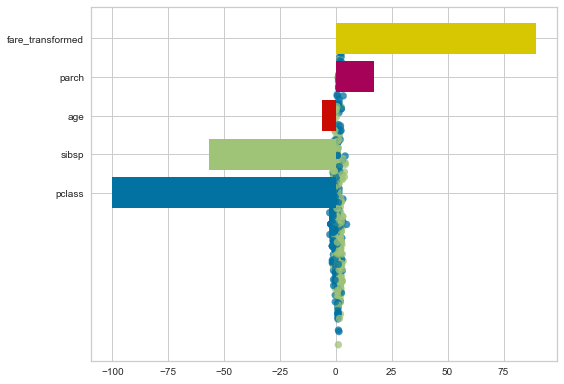

In [22]:
an = eda.Analyser(data = df_data)
an.key_drivers(save_as=".html", y = config_file['target_column'])

#### Data Exploration and story boarding with insights

In [23]:
x = df_data.categorize()
de = eda.DataExplorer(x)
de.open(port=1862)

Launching server at http://localhost:1862


## Model Generation and Data Preparation 

#### Categorical encoding

In [24]:
df_transform = df_data.copy()

## Three types of encodings are available 
## One Hot
## Label Encode 
## Target Encoding

## Target encoding sex and embarked from inference in joint plots.
df_transform['sex'] = dp.Encoder.targetEncode(feature = df_transform['sex'], target = df_transform['survived'])[0]
df_transform['embarked'] = dp.Encoder.targetEncode(feature = df_transform['embarked'], target = df_transform['survived'])[0]
df_transform.head()

### Train - Test Split

##### Once categorical encoding is done, we apply train test split on the dataset. 
##### Stratify = y (to be added in tigerML)

In [25]:
x_train, x_test, y_train, y_test = dp.prep_data(data = df_transform, dv_name = config_file['target_column'], 
                                             train_size = config_file['train_ratio'], remove_outliers = None, 
                                             random_state = config_file['seed'])

Cleaning data
Dropped 0 rows with missing values.
No Infinity values
Have 1 boolean variables. Converting False to 0 and True to 1
No categorical variables in the data


### Feature selection

In [26]:
features, df_feature_sel_metrics = fs.select_features(x_train, y_train, config_file)

selected features: ['age', 'embarked', 'pclass', 'sex', 'sibsp']


In [27]:
x_train = x_train[features]
x_test = x_test[features]

## Different Model Comparison



Data is not passed to ShapExplainer since it is an XGBClassifier.


Data is not passed to ShapExplainer since it is an XGBClassifier.


Data is not passed to ShapExplainer since it is an XGBClassifier.



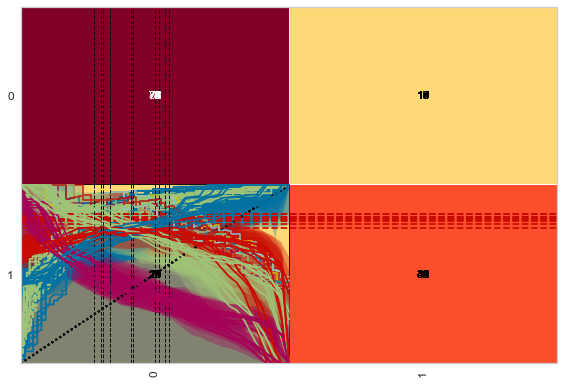

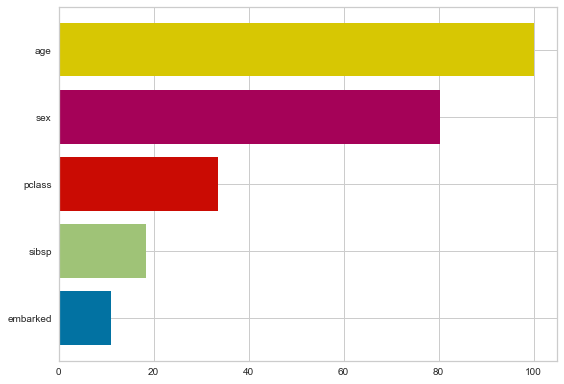

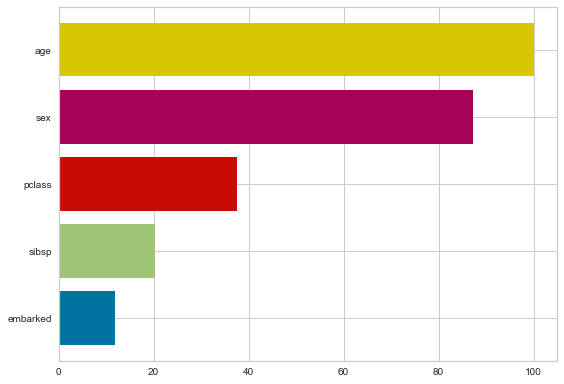

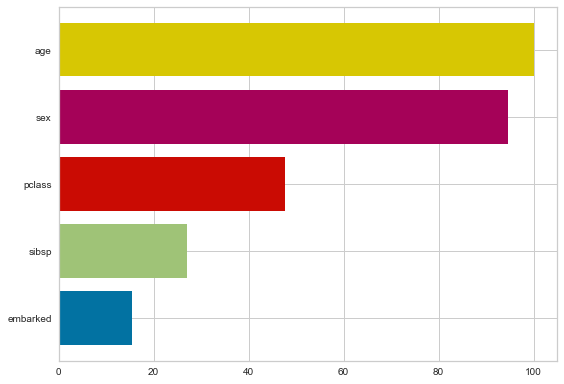

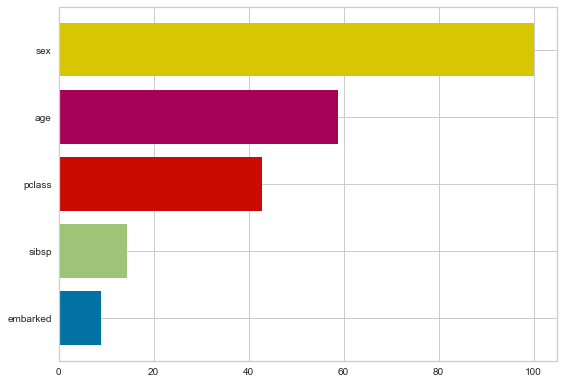

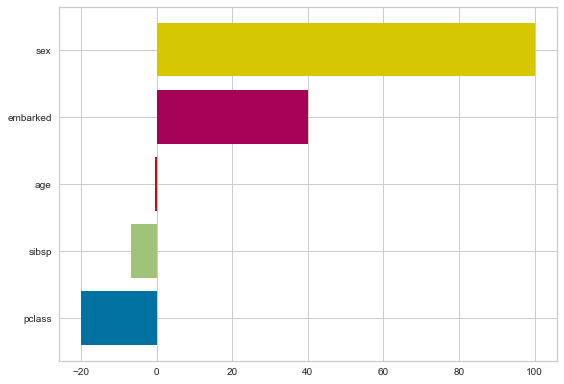

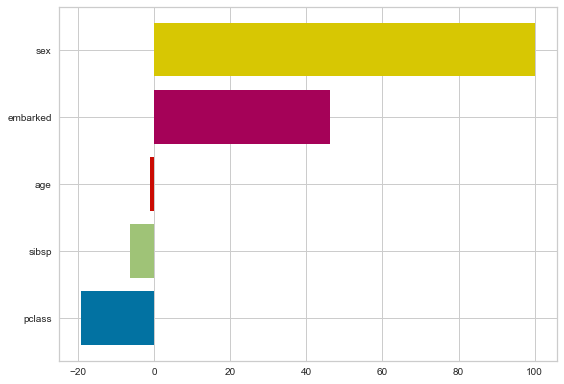

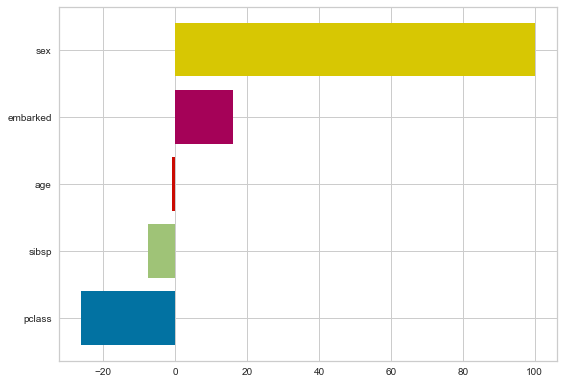

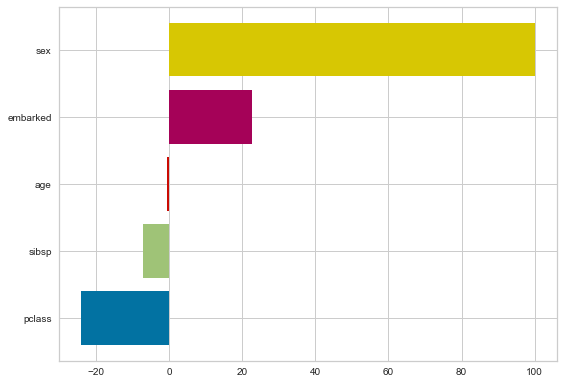

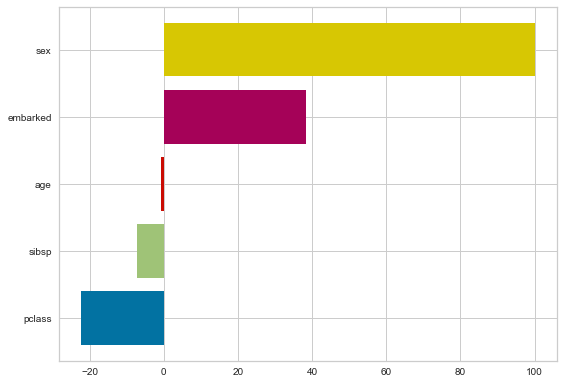

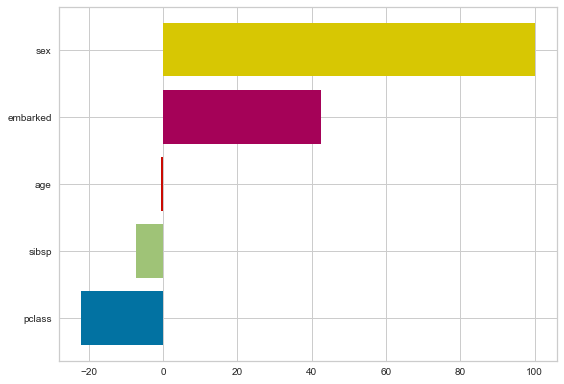

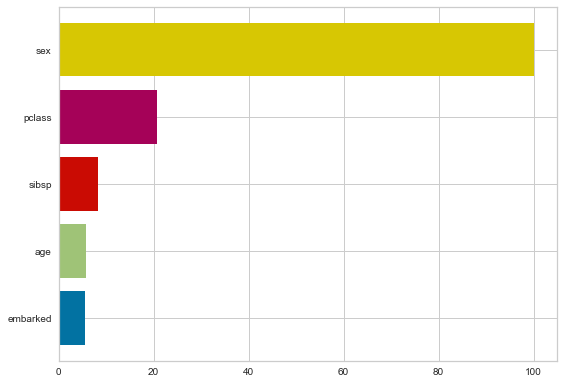

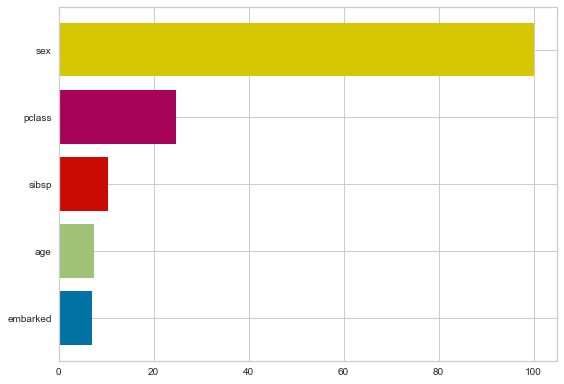

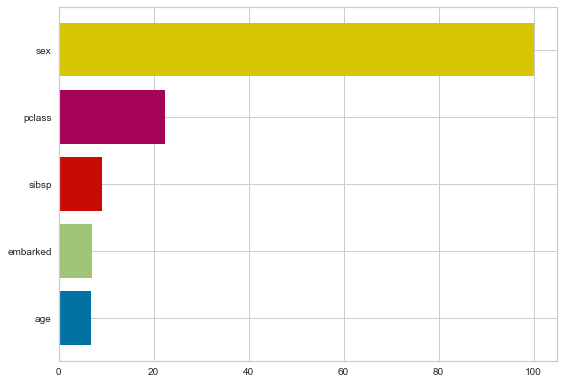

In [28]:
estimator_file= load_yml(config_file['estimator_config_path'])
models=model_gen.list_models_from_config(estimator_file)
rpt=model_eval.ClassificationComparison(models)
rpt.fit(x_train,y_train)
rpt.score(x_test, y_test)
rpt.get_report()

##### Grid search with all types of models in config file with respective parameters. 
##### Best performing model and hyper parameters will be the final result.

In [29]:
best_fit = model_gen.train_model(file_path, x_train, y_train)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=0.932, test=0.800), total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=0.936, test=0.800), total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=0.930, test=0.752), total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_

[CV] . C=1, penalty=l2, score=(train=0.711, test=0.760), total=   0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[CV] C=1, penalty=l2 .................................................
[CV] . C=1, penalty=l2, score=(train=0.812, test=0.744), total=   0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[CV] C=1, penalty=l2 .................................................
[CV] . C=1, penalty=l2, score=(train=0.788, test=0.790), total=   0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
Best estimator : LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 

[CV]  max_depth=6, n_estimators=100, score=(train=0.918, test=0.806), total=   0.1s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=7, n_estimators=100 ...................................
[CV]  max_depth=7, n_estimators=100, score=(train=0.916, test=0.784), total=   0.1s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=7, n_estimators=100 ...................................
[CV]  max_depth=7, n_estimators=100, score=(train=0.920, test=0.792), total=   0.1s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=7, n_estimators=100 ...................................
[CV]  max_depth=7, n_estimators=100, score=(train=0.918, test=0.792), total=   0.1s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=7, n_estimators=100 ...................................
[CV]  max_depth=7, n_estimators=100, score=(train=0.932, tes

## Model Evaluation 

More information on the ClassificationReport is availabe here: https://tigerrepository.github.io/TigerML/build/html/api/model_eval.html#tigerml.model_eval.ClassificationReport

In [30]:
classifier = model_eval.ClassificationReport(best_fit)

##### Fitting best model from gridsearch to the training data.

In [31]:
classifier.fit(x_train, y_train)

##### Scoring on test dataset

In [32]:
classifier.score(x_test, y_test)

In [33]:
classifier.model.predict_proba(x_test)

array([[0.88986705, 0.11013295],
       [0.84761201, 0.15238799],
       [0.87553051, 0.12446949],
       [0.88236739, 0.11763261],
       [0.7971907 , 0.2028093 ],
       [0.06510749, 0.93489251],
       [0.9823283 , 0.0176717 ],
       [0.67116852, 0.32883148],
       [0.11752213, 0.88247787],
       [0.02339874, 0.97660126],
       [0.05852748, 0.94147252],
       [0.1169476 , 0.8830524 ],
       [0.86810611, 0.13189389],
       [0.88894837, 0.11105163],
       [0.74464609, 0.25535391],
       [0.53274102, 0.46725898],
       [0.04746782, 0.95253218],
       [0.88236739, 0.11763261],
       [0.86025944, 0.13974056],
       [0.09741601, 0.90258399],
       [0.85496353, 0.14503647],
       [0.91111172, 0.08888828],
       [0.85846332, 0.14153668],
       [0.91630971, 0.08369029],
       [0.12323773, 0.87676227],
       [0.01085208, 0.98914792],
       [0.012595  , 0.987405  ],
       [0.61995342, 0.38004658],
       [0.79622249, 0.20377751],
       [0.87058743, 0.12941257],
       [0.

In [34]:
classifier.model.predict(x_test)

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0], dtype=int64)

:Curve   [False Positive Rate]   (True Positive Rate)

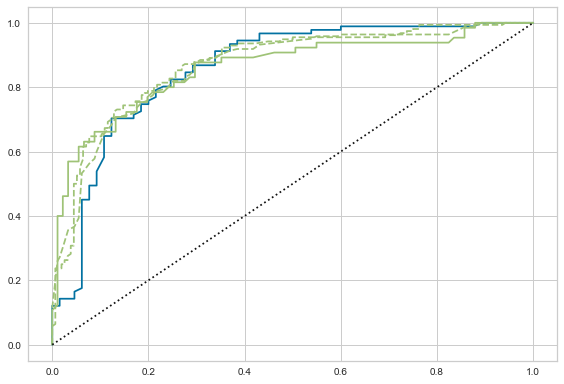

In [35]:
classifier.evaluator.roc_curve()

In [36]:
classifier.evaluator.confusion_matrix()

dataset          train                    test            
metric     predicted_0 predicted_1 predicted_0 predicted_1
true_label                                                
0                  340          27          77          14
1                   57         200          19          46

In [37]:
best_fit

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [38]:
classifier.get_report()

10 instances are false positives
9 instances are false negatives


### Confusion Matrix component analysis

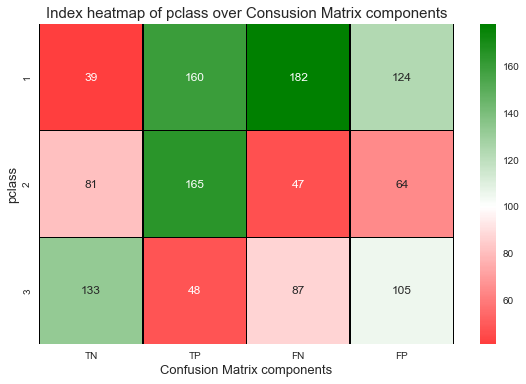

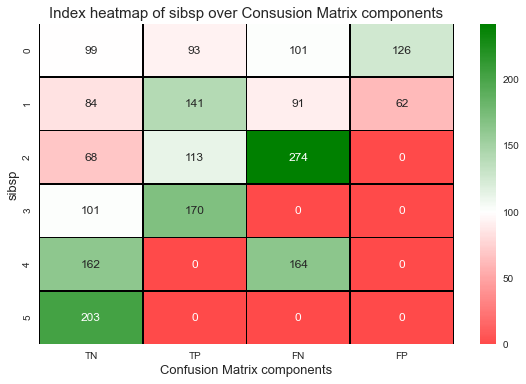

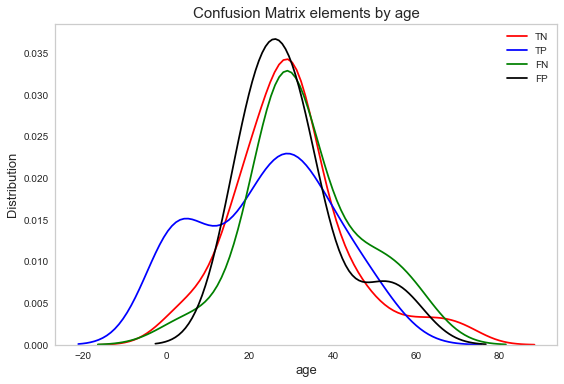

In [39]:
x_eval = x_test.copy()
x_eval['prediction'] = best_fit.predict(x_eval)
x_eval['actuals'] = y_test.reset_index(drop = True).iloc[:,0].values

eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='pclass',categorical=True)
eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='sibsp',categorical=True)
eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='embarked',categorical=False)
eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='age',categorical=False)


The value indicates the index as a ratio of proportion of (TN/TP/FN/FP) in the class and proportion of TN/TP/FN/FP overall. For example, class 0 is 80% of the entire population but it is 20% in FP. So the index is 25.

Here value = 0 means no value presents in that class for that metric. So, 0 is desirable for FN and FP columns. Value = 100 indicate equal representation in both population and TN/TP/FN/FP.

We can tune the features and class where the value is much higer than 100.

For continuous variables, we see that in between certain values the TN/TP value below FP/FN indicating that in those range some tuning is required.